<a href="https://colab.research.google.com/github/Rama389/AI-Projects/blob/main/Supervised_Learning_Pairwise_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pair-wise Classifier

In [ ]:
# ================================================
# Pairwise Classifier Experiment on Character Dataset
# ================================================
# This script:
# 1. Loads dataset (expects CSV with "labels" column + pixel columns).
# 2. Removes all-zero pixel columns.
# 3. Normalizes pixel values to [0,1].
# 4. Keeps only capital letters A–Z.
# 5. Splits each class into 70% train, 30% test (stratified).
# 6. For each class pair:
#    - Compute Fisher scores per pixel on training samples
#    - Pick top 30 discriminative pixels
#    - Train linear SVM on those features
#    - Evaluate accuracy on test samples
# 7. Saves results:
#    - pairwise_accuracies.csv (Class-1, Class-2, Accuracy)
#    - top30_by_pair.json (pixel indices selected for each pair)

# ================================================
# Setup
# ================================================
import pandas as pd
import numpy as np
import itertools, json, time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

# ================================================
# Load dataset
# ================================================
# In Colab, first upload file:
# from google.colab import files
# uploaded = files.upload()
# Then set path to your file, e.g.:
# path = "tmnst Dataset.csv"
path = "tmnst Dataset.csv"

df = pd.read_csv(path)

# Detect label column (adjust if different)
if 'labels' in df.columns:
    label_col = 'labels'
else:
    label_col = df.columns[0]

labels = df[label_col].astype(str).values
pixels = df.drop(columns=[label_col]).copy()

# ================================================
# Preprocess
# ================================================
# Remove all-zero columns
nonzero_cols = pixels.columns[(pixels != 0).any(axis=0)]
pixels = pixels[nonzero_cols]

# Normalize to [0,1]
if pixels.values.max() > 1.01:
    pixels = pixels / 255.0

X = pixels.values
y = labels

# Keep only uppercase A–Z
mask_keep = np.isin(y, list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
X = X[mask_keep]
y = y[mask_keep]

# ================================================
# Train/test split (per class, 70/30)
# ================================================
train_idx, test_idx = [], []
unique_classes = np.unique(y)

for cls in unique_classes:
    idxs = np.where(y == cls)[0]
    if len(idxs) < 2:
        train_idx.extend(idxs.tolist())
        continue
    tr, te = train_test_split(idxs, train_size=0.7, random_state=42, shuffle=True)
    train_idx.extend(tr.tolist())
    test_idx.extend(te.tolist())

train_idx = np.array(sorted(train_idx))
test_idx = np.array(sorted(test_idx))

Xtr_all, ytr_all = X[train_idx], y[train_idx]
Xte_all, yte_all = X[test_idx], y[test_idx]

print("Train size:", Xtr_all.shape, "Test size:", Xte_all.shape)

# ================================================
# OPTIONAL: Subsample for speed
# ================================================
# Uncomment these lines if training is too slow.
# For full dataset, just skip this section.

max_train_per_class = 500   # cap per-class train samples
max_test_per_class  = 200   # cap per-class test samples

train_pos, test_pos = {}, {}
rng = np.random.RandomState(42)

for cls in unique_classes:
    pos_tr = np.where(ytr_all == cls)[0]
    pos_te = np.where(yte_all == cls)[0]

    if pos_tr.size > max_train_per_class:
        pos_tr = rng.choice(pos_tr, size=max_train_per_class, replace=False)
    if pos_te.size > max_test_per_class:
        pos_te = rng.choice(pos_te, size=max_test_per_class, replace=False)

    train_pos[cls] = pos_tr
    test_pos[cls]  = pos_te

# Precompute mean/var for Fisher scores
class_stats = {}
for cls in unique_classes:
    pos = train_pos[cls]
    if pos.size == 0:
        class_stats[cls] = {
            'mean': np.zeros(Xtr_all.shape[1]),
            'var' : np.ones(Xtr_all.shape[1])
        }
    else:
        Xc = Xtr_all[pos]
        class_stats[cls] = {
            'mean': Xc.mean(axis=0),
            'var' : Xc.var(axis=0, ddof=1)
        }

# ================================================
# Pairwise classification
# ================================================
pairs = list(itertools.combinations(sorted(unique_classes), 2))
results = []
top30_by_pair = {}

start = time.time()
for (a, b) in pairs:
    if train_pos[a].size == 0 or train_pos[b].size == 0: continue
    if test_pos[a].size == 0 or test_pos[b].size == 0: continue

    mu1, mu2 = class_stats[a]['mean'], class_stats[b]['mean']
    var1, var2 = class_stats[a]['var'], class_stats[b]['var']

    scores = (mu1 - mu2) ** 2 / (var1 + var2 + 1e-12)
    top30_idx = np.argsort(scores)[-30:][::-1]
    top30_by_pair[f"{a}_{b}"] = top30_idx.tolist()

    # Training / testing data for this pair
    tr_idx = np.concatenate([train_pos[a], train_pos[b]])
    te_idx = np.concatenate([test_pos[a], test_pos[b]])

    Xtr, ytr = Xtr_all[tr_idx][:, top30_idx], ytr_all[tr_idx]
    Xte, yte = Xte_all[te_idx][:, top30_idx], yte_all[te_idx]

    clf = LinearSVC(C=1.0, dual=False, max_iter=2000)
    clf.fit(Xtr, ytr)
    acc = clf.score(Xte, yte)

    results.append((a, b, acc))
end = time.time()

print(f"Finished {len(results)} pairs in {end-start:.1f}s")

# ================================================
# Save results
# ================================================
out_df = pd.DataFrame(results, columns=["Class-1", "Class-2", "Validation-Set-Accuracy"])
out_df.to_csv("pairwise_accuracies.csv", index=False)

with open("top30_by_pair.json", "w") as f:
    json.dump(top30_by_pair, f)

print("Results saved to pairwise_accuracies.csv and top30_by_pair.json")

# ================================================
# Quick summary
# ================================================
print("Min acc:", out_df["Validation-Set-Accuracy"].min())
print("Mean acc:", out_df["Validation-Set-Accuracy"].mean())
print("Median acc:", out_df["Validation-Set-Accuracy"].median())
print("Max acc:", out_df["Validation-Set-Accuracy"].max())

print("\nHardest 10 pairs:")
print(out_df.sort_values("Validation-Set-Accuracy").head(10))

print("\nEasiest 10 pairs:")
print(out_df.sort_values("Validation-Set-Accuracy", ascending=False).head(10))


Train size: (52286, 689) Test size: (22438, 689)
Finished 325 pairs in 2.1s
Results saved to pairwise_accuracies.csv and top30_by_pair.json
Min acc: 0.905
Mean acc: 0.9753923076923077
Median acc: 0.9775
Max acc: 0.9975

Hardest 10 pairs:
    Class-1 Class-2  Validation-Set-Accuracy
172       I       J                   0.9050
82        D       O                   0.9150
260       O       Q                   0.9225
144       G       Q                   0.9275
21        A       W                   0.9375
16        A       R                   0.9400
29        B       G                   0.9425
310       U       V                   0.9425
6         A       H                   0.9425
168       H       W                   0.9450

Easiest 10 pairs:
    Class-1 Class-2  Validation-Set-Accuracy
213       K       T                   0.9975
252       N       T                   0.9950
301       S       X                   0.9950
208       K       O                   0.9950
276       P       W    

Recommendations:



1.   The hardest pairs are I-J, D-O, O-Q, G-Q, A-W, A-R, B-G, U-V, A-H, H-W
2.   The eaiest pairs are K-T, N-T, S-X, K-O, P-W, C-X, E-V, R-T, B-J, C-K



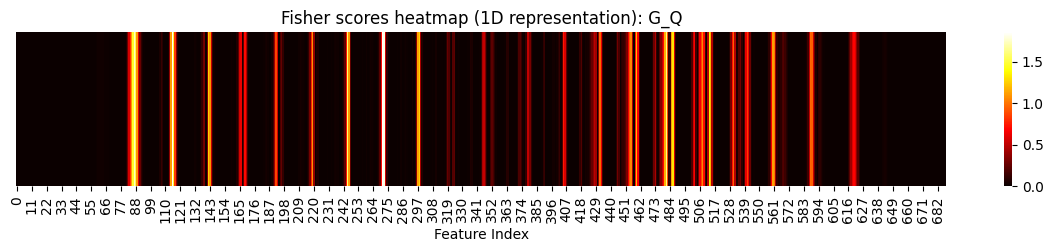

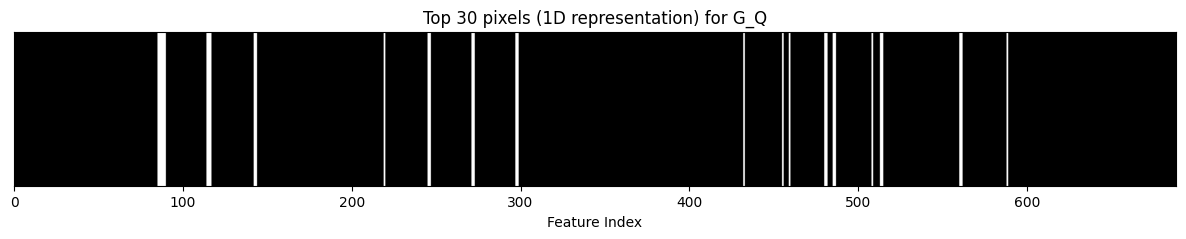

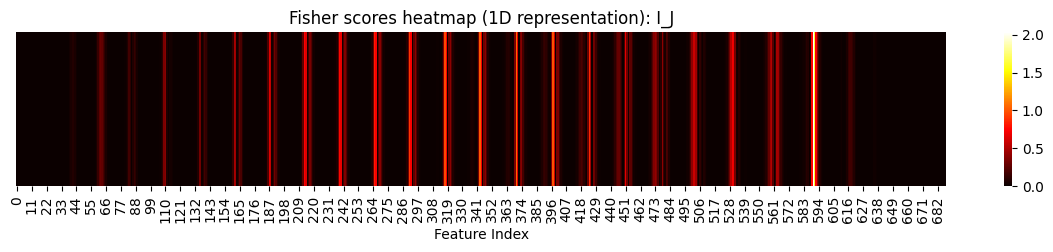

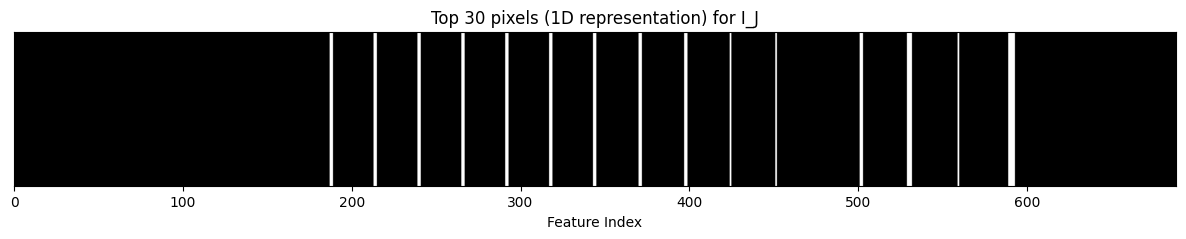

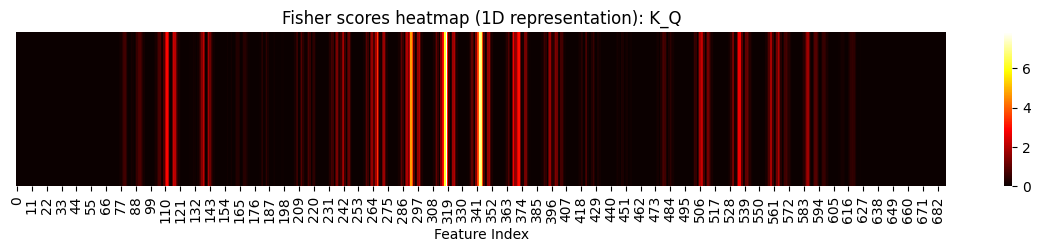

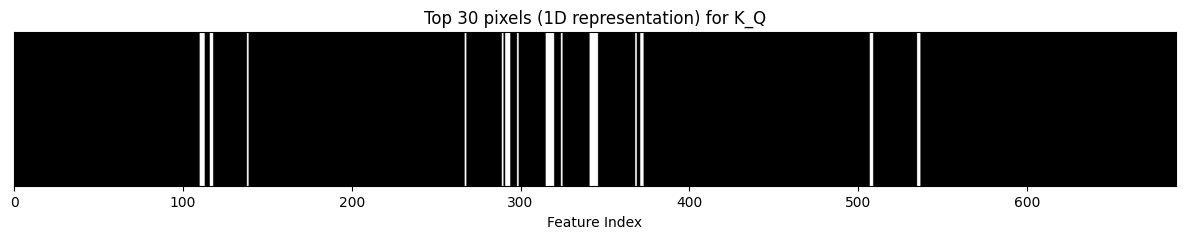

In [ ]:
# ================================================
# Visualization functions
# ================================================
# Assume 28x28 image shape (like MNIST). Change if different.
# NOTE: After removing zero-only columns, the number of features is 689, not 784.
# Direct reshaping to a 28x28 grid is not possible without the original column mapping.
# We will visualize the scores and top pixels on a 1D representation of the features.
num_features = 689

def show_top_pixels(pair_key, scores=None, topn=30):
    """
    Visualize top discriminative pixels for a given pair on a 1D representation.
    pair_key should be string like "G_Q"
    """
    if pair_key not in top30_by_pair:
        print("Pair not found!")
        return
    top_idx = top30_by_pair[pair_key]

    # If Fisher scores not provided, recompute
    if scores is None:
        a, b = pair_key.split("_")
        # Ensure class_stats is available (from the training cell)
        if 'class_stats' not in globals():
             print("Error: class_stats not found. Please run the training cell first.")
             return

        mu1, mu2 = class_stats[a]['mean'], class_stats[b]['mean']
        var1, var2 = class_stats[a]['var'], class_stats[b]['var']
        scores = (mu1 - mu2) ** 2 / (var1 + var2 + 1e-12)

    # Reshape scores to a single row for heatmap visualization
    score_img_1d = scores.reshape(1, num_features)

    plt.figure(figsize=(15, 2)) # Adjust figure size for 1D heatmap
    sns.heatmap(score_img_1d, cmap="hot", cbar=True, square=False, yticklabels=False)
    plt.title(f"Fisher scores heatmap (1D representation): {pair_key}")
    plt.xlabel("Feature Index")
    plt.show()

    # Create a mask for top pixels on the 1D representation
    mask_1d = np.zeros(num_features)
    mask_1d[top_idx] = 1
    mask_img_1d = mask_1d.reshape(1, num_features)

    plt.figure(figsize=(15, 2)) # Adjust figure size for 1D mask
    plt.imshow(mask_img_1d, cmap="gray", aspect='auto') # Use aspect='auto' for 1D
    plt.title(f"Top {topn} pixels (1D representation) for {pair_key}")
    plt.xlabel("Feature Index")
    plt.axis("on") # Keep axis on to show feature indices
    plt.yticks([]) # Hide y-axis ticks for 1D visualization
    plt.show()

# ================================================
# Example visualizations
# ================================================
# Try some hard/easy pairs after training:
show_top_pixels("G_Q")
show_top_pixels("I_J")
show_top_pixels("K_Q")   # an easy pair

Recommendations:

The above heat map shows the easy and hardiest pairs.